# Модерация токсичных комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Требуется обучить модель классифицировать комментарии на позитивные и негативные при помощи имеющегося набора данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка библиотек, классов и метрик

In [1]:
#
!pip install --upgrade scikit-learn=='1.4.0' -q
#!pip install phik -q
!pip install catboost -q
!pip install pandarallel -q

# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy -q
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en_core_web_sm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Лемматизация и очистка:
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию

import spacy


from sklearn.feature_extraction.text import TfidfVectorizer

# загрузка моделей и метрик
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

from pandarallel import pandarallel

import torch
import transformers
from tqdm import notebook

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Загрузка данных и знакомство с ними

In [3]:
import os

pth1 = '/datasets/toxic_comments.csv'
pth2 = '/content/toxic_comments.csv'

if os.path.exists(pth1):
    toxic_comments = pd.read_csv(pth1, sep=',', index_col=[0])
elif os.path.exists(pth2):
    toxic_comments = pd.read_csv(pth2, sep=',', index_col=[0])
else:
    print('PathError')

In [4]:
toxic_comments.info()

toxic_comments.head()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
print("Количество нулевых значений:", toxic_comments.isnull().sum())
print('_____________________')
print("Количество дубликатов:", toxic_comments[toxic_comments.duplicated()])

Количество нулевых значений: text     0
toxic    0
dtype: int64
_____________________
Количество дубликатов: Empty DataFrame
Columns: [text, toxic]
Index: []


В датафрейме 2 столбца, нулевых значений нет, дубликатов нет, всего строк 159292

In [6]:
#Посчитаем количества значений "0" и "1" ("нетоксичный"/"токсичный")
display(toxic_comments['toxic'].value_counts())
#Рассчитаем соотношение нетоксичных к токсичным
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

,count
toxic,
0,143106
1,16186


8.841344371679229

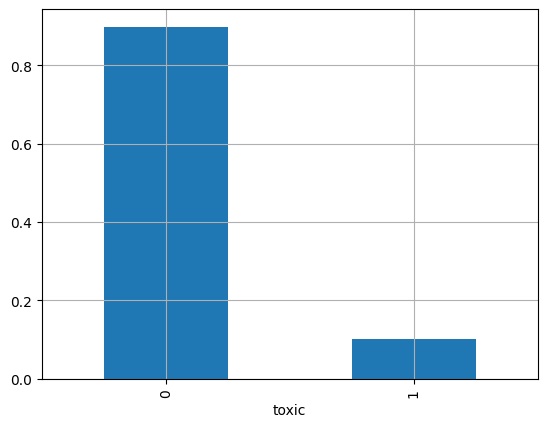

Нулевой класс превышает первый на 79.68%


In [7]:
#Визуализируем дисбаланс
class_count = toxic_comments['toxic'].value_counts(normalize = (0,1))
class_count.plot(kind = 'bar', grid = True)
plt.show()

print('Нулевой класс превышает первый на {:.2%}'.format(class_count[0] - class_count[1]))

**Налицо дисбаланс классов, который может сказаться на метрике F1. Необходимо сбалансировать классы при обучении модели, чтобы минимизировать ошибку FP**

### Лемматизация и очистка текста

In [8]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
lemmatize = nltk.WordNetLemmatizer()

def lemmatize_text(row):
    text = re.sub('[^a-zA-Z]', ' ', row.text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматизируем слова
    row['lemm_text'] = ' '.join(text) # соединяем слова
    return row

comments = toxic_comments.parallel_apply(lemmatize_text, axis=1)

In [10]:
display(toxic_comments.head())
print("_"*100)
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


____________________________________________________________________________________________________


,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Получилось не очень качественно, посколькучасть слов не переведены в леммы. Попробуем **SpaCy**.

In [11]:
# Инициализируем spacy 'en_core_web_sm' модель, оставляя tagger component необходимый для лемматизации
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def spacy_lemmatize(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    lemmatized_output = ' '.join([w.lemma_ for w in clean])
    return lemmatized_output

#toxic_comments['spacy_lemmatize'] = toxic_comments['text'].apply(spacy_lemmatize)

In [12]:

# Проверка работы функции
sentence1 = "The striped bats are hanging on their feet - for best"
sentence2 = "@you! should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
display(df_my)


display(df_my['text'].apply(spacy_lemmatize))


,text
0,The striped bats are hanging on their feet - f...
1,@you! should be ashamed of yourself went worked


,text
0,the stripe bat be hang on their foot for good
1,you should be ashamed of yourself go work


In [13]:
toxic_comments['spacy_lemmatize'] = toxic_comments['text'].apply(spacy_lemmatize)

In [14]:
toxic_comments

,text,toxic,spacy_lemmatize
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there s no actual article for pros...
159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [15]:
#toxic_comments['spacy_lemmatize'] = toxic_comments['text'].parallel_apply(spacy_lemmatize)

In [16]:
comments_spl = toxic_comments.drop(['text'], axis = 1)

Отлично, текст очищен и лемматизирован, дальше можно работать с полученным датасетом `comments_spl`

In [17]:
RANDOM_STATE = 42

#делим датасет на выборки
y = comments_spl['toxic']
X = comments_spl.drop(['toxic'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=RANDOM_STATE)

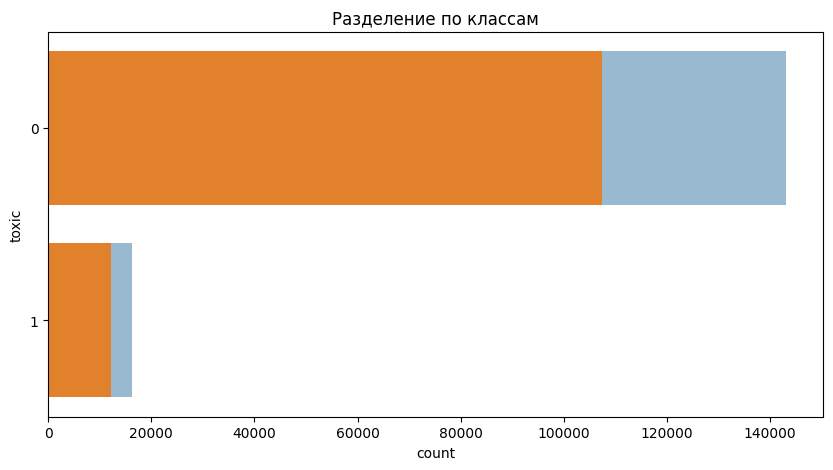

In [18]:
train = pd.DataFrame(y, columns=['toxic'])
test = pd.DataFrame(y_test, columns=['toxic'])

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=train, y='toxic', alpha=.5)
sns.countplot(data=test, y='toxic', alpha=1)
ax.set_title('Разделение по классам')
plt.show()

In [19]:
stopwords = set(nltk_stopwords.words('english'))
stopwords = list(stopwords)
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [20]:
X_train.shape
X_train.head()

,spacy_lemmatize
39561,a kitten for you we have the same name
91877,he very rarely credit himself he be pretty hum...
111799,correct and True Etymology of English word Myt...
72606,actually since I m just a little bitch I m go ...
157934,derivative work please add the below text in d...


In [21]:
tf_idf_X_train = count_tf_idf.fit_transform(X_train['spacy_lemmatize'])
tf_idf_X_test = count_tf_idf.transform(X_test['spacy_lemmatize'])
print(tf_idf_X_train.shape)
print(tf_idf_X_test.shape)

(39823, 68831)
(119469, 68831)


## Обучение

### LogisticRegression

In [22]:
%%time

lg_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

#настраиваем поиск по сетке
# параметры
lg_params = {'solver':['newton-cg', 'lbfgs', 'liblinear'],
             #'C':[0.1, 1, 10],
             'C' : range(1,15,1),
             'penalty': ['l1','l2']
             }

lg_gs_model = GridSearchCV(lg_model,
                             lg_params,
                             cv=5,
                             scoring = 'f1',
                             n_jobs=-1)

lg_gs_model.fit(tf_idf_X_train, y_train)
lg_gs_model.best_params_

print('Лучшие параметры модели LogisticRegression:\n\n', lg_gs_model.best_params_)
print('F1 на кросс-валидации', lg_gs_model.best_score_)

Лучшие параметры модели LogisticRegression:

 {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}
F1 на кросс-валидации 0.7601035972388275
CPU times: user 7.97 s, sys: 1.33 s, total: 9.31 s
Wall time: 7min 44s


In [23]:
result=[]
d1 = {'model': 'LogisticRegression', 'F1': lg_gs_model.best_score_}
result = pd.DataFrame.from_records([d1])
result

,model,F1
0,LogisticRegression,0.760104


### DecisionTreeClassifier

In [24]:
%%time

dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

#настраиваем поиск по сетке
# параметры
dt_params = {
    #'max_features': range(15, 20, 5),
    'max_depth': range(70, 130, 20),
    #'min_samples_leaf': range(2,5),
    #'min_samples_split': range(4,8,2)
                }

dt_gs_model = GridSearchCV(dt_model,
                             dt_params,
                             cv=5,
                             scoring = 'f1',
                             n_jobs=-1)

dt_gs_model.fit(tf_idf_X_train, y_train)
dt_gs_model.best_params_

print('Лучшие параметры модели DecisionTreeClassifier:\n\n', dt_gs_model.best_params_)
print('F1 на кросс-валидации', dt_gs_model.best_score_)

Лучшие параметры модели DecisionTreeClassifier:

 {'max_depth': 90}
F1 на кросс-валидации 0.6385011367257989
CPU times: user 27 s, sys: 614 ms, total: 27.6 s
Wall time: 5min 45s


In [25]:
result=[]
d1 = {'model': 'LogisticRegression', 'F1': lg_gs_model.best_score_}
d2 = {'model': 'DecisionTreeClassifier', 'F1': dt_gs_model.best_score_}
result = pd.DataFrame.from_records([d1, d2])
result

,model,F1
0,LogisticRegression,0.760104
1,DecisionTreeClassifier,0.638501


### CatBoost

In [26]:
%%time
#инициализируем модель
ctb_model = CatBoostClassifier(random_state=RANDOM_STATE,
                              #class_weight='balanced',
                              verbose = False,
                               depth = 6,
                               iterations=200)

# подбор параметров
catb_params = {
    #"n_estimators": [400, 600],
    'learning_rate': [0.01, 0.1],
              }
#настраиваем поиск по сетке
catb_gs_model = GridSearchCV(ctb_model,
                             catb_params,
                             cv=2,
                             scoring ='f1',
                             n_jobs=4)


catb_gs_model.fit(tf_idf_X_train, y_train)
catb_gs_model.best_params_
print('Лучшая модель и её параметры:\n\n', catb_gs_model.best_params_)
print('F1 на кросс-валидации', catb_gs_model.best_score_)

Лучшая модель и её параметры:

 {'learning_rate': 0.1}
F1 на кросс-валидации 0.685307858829078
CPU times: user 5min 21s, sys: 4.07 s, total: 5min 25s
Wall time: 13min 7s


### Анализ итоговой таблицы и предсказание лучшей модели

In [27]:
result=[]
d1 = {'model': 'LogisticRegression', 'F1': lg_gs_model.best_score_}
d2 = {'model': 'DecisionTreeClassifier', 'F1': dt_gs_model.best_score_}
d3 = {'model': 'CatBoost', 'F1': catb_gs_model.best_score_}
result = pd.DataFrame.from_records([d1, d2, d3])
result

,model,F1
0,LogisticRegression,0.760104
1,DecisionTreeClassifier,0.638501
2,CatBoost,0.685308


Лучшую метрику на кросс-валидации показывает модель Logisticregression. Метрика равна 0,7601. остальные две модели требования к значению метрики (не ниже 0,75) не проходят. Рекомендуем к работе модель Logisticregression.

Проверим ее на тестовой выборке:

In [28]:

y_pred = lg_gs_model.predict(tf_idf_X_test)

F1 =  f1_score (y_test, y_pred)
print(f'Метрика F1 LGBMRegressor = {F1:.4f}')

Метрика F1 LGBMRegressor = 0.7561


## Выводы

- Обучены 3 модели: Logisticregression, DecisionTreeClassifier и CatBoost. Параметры подобраны на тренировочной выборке, на кросс-валидации определена метрика F1 для каждой модели.
- Лучшая модель по итогам проверки на кросс-валидации - это модель Logisticregression с метрикой F1 = 0,7601
- Модель Logisticregression рекомендована к работе, проверена на тестовой выборке и выдает метрику для предсказания на ней, равную 0,7561

**ToDo**:

Кросс-валидация одновремено с извлечением признаков из текстов требует особого подхода.
В данном случае векторайзер обучался на обучающей выборке а применялся к тестовой. При кросс-валидации большую обучающую выборку разбиваем на несколько фолдов, из них выделяем часть на обучение, часть на валидацию. Но при этом признаки (TF-IDF) уже обучены на всем наборе (обучающий + валидационный). Таким образом, получается утечка данных.
 Чтобы избежать её нужно использовать pipeline из векторайзера и модели.

 **ToDo**: научиться собирать пайплайн из векторайзера и модели (на этапе обучения не получилось, поскольку не успела разобраться, как задействовать GPU для ускорения работы модели)